# Abstraction Alignment on a Toy Example

We apply abstraction alignment in a synthetic setting where we have enforced a hierarchical relationship in the model's behavior. First, we generating synthetic image data with inherent hierarchical structure. Then we train a simple neural network classifier on the data and analyze how well the model's behavior aligns with the known hierarchical structure.

In [1]:
%load_ext autoreload
%autoreload 2

In [32]:
import numpy as np
import os
from matplotlib import pyplot as plt
import random
import torch
import torch.nn as nn
from tqdm import tqdm
from treelib import Tree
from scipy import stats

import metrics
from abstraction_graph_toy_example import make_abstraction_graph, show_abstraction_graph, propagate
from util.toy_example.data_generation import SyntheticDataGenerator, create_dataloaders

## Generating the Synthetic Dataset
We generate synthetic 4x4 RGB images with three classes. These classes are the result of a higher-order structure. We can think of these classes are image generation functions, where sometimes two generation functions share a higher-level parent function.

```
-Parent 0: Images with three corners sharing the same color
--Class 0: Images with three corners sharing the same color
-Parent 1: Images with two four-pixel same-color segments
--Class 1: Images with two specific quadrants sharing the same color
--Class 2: Images with alternating columns of the same color
```

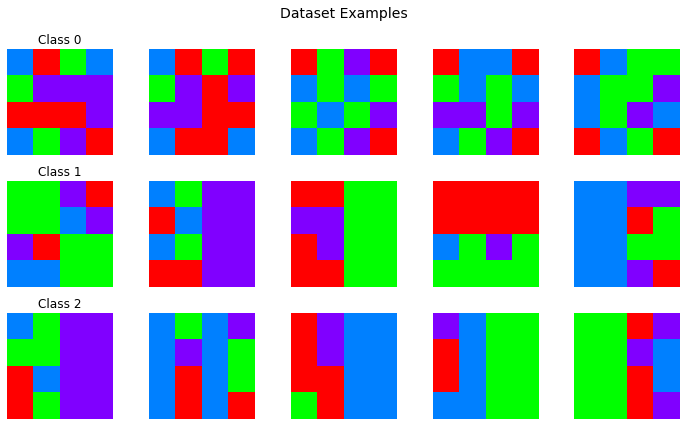

In [4]:
generator = SyntheticDataGenerator(image_size=4)
generator.show_examples(5)

In [5]:
train_loader, test_loader = create_dataloaders(
    train_samples_per_class = 1500,
    test_samples_per_class= 500,
    batch_size = 32,
    num_workers = 4)

# Print dataset information
print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")
    
# Example of batch structure
for images, labels in train_loader:
    print(f"Batch shapes:")
    print(f"  Images: {images.shape}")
    print(f"  Labels: {labels.shape}")
    break  # Just show first batch

Training batches: 141
Test batches: 47
Batch shapes:
  Images: torch.Size([32, 48])
  Labels: torch.Size([32])


## Training a Small Model
We train a linear model with ReLU on the dataset to classify images into one of the three classes. Since there is some overlap between classes 1 and 2, the model should experience confusion between the two.

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 3
input_size = train_loader.dataset[0][0].shape[-1]
hidden_dim = 20

model = nn.Sequential(
    nn.Linear(input_size, hidden_dim),
    nn.ReLU(),
    nn.Linear(hidden_dim, num_classes)
).to(device)

In [7]:
def evaluate_model(model, data_loader, device):
    """
    Evaluate model accuracy on a dataset.
    
    Args:
        model: Neural network model
        data_loader: DataLoader containing the evaluation dataset
        device: Device to run evaluation on
        
    Returns:
        float: Accuracy score (0-1)
    """
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device).float()
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return correct / total

In [8]:
def train_model(model, train_loader, test_loader, num_epochs=200, learning_rate=0.001):
    """
    Train the neural network model.
    
    Args:
        model: Neural network model
        train_loader: DataLoader for training data
        test_loader: DataLoader for test data
        num_epochs: Number of training epochs
        learning_rate: Learning rate for optimizer
        
    Returns:
        Training losses and accuracies per epoch
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    train_losses = []
    train_accuracies = []
    
    pbar = tqdm(range(num_epochs), desc="Training")
    for epoch in pbar:
        model.train()
        epoch_losses = []
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images = images.to(device).float()
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Track statistics
            epoch_losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # Calculate epoch statistics
        epoch_loss = sum(epoch_losses) / len(epoch_losses)
        epoch_accuracy = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        
        # Update progress bar every epoch
        if epoch % 10 == 0:
            test_accuracy = evaluate_model(model, test_loader, device)
        else:
            test_accuracy = train_accuracies[-1]  # Use training accuracy when not computing test
            
        pbar.set_postfix({
            'epoch': f'{epoch:3d}',
            'loss': f'{epoch_loss:.4f}',
            'train_acc': f'{epoch_accuracy:.4f}',
            'test_acc': f'{test_accuracy:.4f}'
        })
    
    return train_losses, train_accuracies

In [9]:
loss, accuracy = train_model(model, train_loader, test_loader, num_epochs=200, learning_rate=0.001)

Training: 100%|███████████████████████████████████████| 200/200 [03:29<00:00,  1.05s/it, epoch=199, loss=0.1450, train_acc=0.9376, test_acc=0.9376]


In [10]:
# Compute model outputs on test instances
labels = []
outputs = []

for i, (image, label) in enumerate(tqdm(test_loader)):
    with torch.no_grad():
        images = image.to(device).float()
    labels.extend(label.numpy())

    # Compute model inferences
    output = model(images)
    output = torch.nn.functional.softmax(output, dim=1).squeeze(0).detach().cpu().numpy()
    outputs.append(output)
    
outputs = np.vstack(outputs)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 135.75it/s]


## Define the Abstraction Graph
We define the abstraction graph based on human similarity. Images in classes 1 and 2 are more similar to each other than images in class 0.

In [33]:
abstraction_graph = make_abstraction_graph()
print(show_abstraction_graph(abstraction_graph))
print(f'Abstraction graph with {abstraction_graph.size()} nodes across {abstraction_graph.depth() + 1} levels.')

root (None)
├── parent0 (None)
│   └── child0 (None)
└── parent1 (None)
    ├── child1 (None)
    └── child2 (None)

Abstraction graph with 6 nodes across 3 levels.


## Measure Abstraction Alignment
We show that the model is abstractio aligned by measuring its abstraction match --- i.e., how much of its entropy in the model's predictions is reduced by moving up a level of abstraction.

First, we measure abstraction alignment using the real abstraction graph. This abstraction graph represents the abstractions we expect the model to learn.

In [34]:
aligned_abstraction_graphs = []
for i in range(len(labels)):
    abstraction_graph = propagate(outputs[i], make_abstraction_graph())
    aligned_abstraction_graphs.append(abstraction_graph)

In [35]:
abstraction_match = metrics.abstraction_match(aligned_abstraction_graphs, 1)
print(f'Abstraction match = {abstraction_match:.2%}')

Abstraction match = 75.51%


Then, we measure abstraction match using a misaligned abstraction graph. The misaligned abstraction graph does not align with the abstractions we expect the model to learn.

In [37]:
misaligned_abstraction_graphs = []
for i in range(len(labels)):
    abstraction_graph = propagate(outputs[i], make_abstraction_graph(misaligned=True))
    misaligned_abstraction_graphs.append(abstraction_graph)
abstraction_match = metrics.abstraction_match(misaligned_abstraction_graphs, 1)
print(f'Abstraction match with misaligned graph = {abstraction_match:.2%}')

Abstraction match with misaligned graph = 13.98%


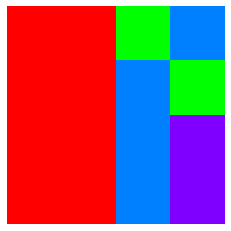

MODEL PREDICTIONS:  ['1 (0.64)', '2 (0.36)', '0 (0.00)']
ALIGNED ABSTRACTION GRAPH:
root (1.00)
├── parent0 (0.00)
│   └── child0 (0.00)
└── parent1 (1.00)
    ├── child1 (0.64)
    └── child2 (0.36)

MISALIGNED ABSTRACTION GRAPH:
root (1.00)
├── parent0 (0.64)
│   ├── child0 (0.00)
│   └── child1 (0.64)
└── parent1 (0.36)
    └── child2 (0.36)



In [38]:
# An example comparing aligned and misaligned abstraction alignment
index = 510
image = test_loader.dataset[index][0].detach().cpu().numpy()
image = np.reshape(image, (4, 4, 3)) * 255

plt.imshow(image.astype(int))
plt.axis('off')
plt.show()

top_predictions = np.argsort(outputs[index])[-3:]
print('MODEL PREDICTIONS: ', [f'{i} ({outputs[index][i]:.2f})' for i in top_predictions][::-1])

print('ALIGNED ABSTRACTION GRAPH:')
print(show_abstraction_graph(aligned_abstraction_graphs[index]))

print('MISALIGNED ABSTRACTION GRAPH:')
print(show_abstraction_graph(misaligned_abstraction_graphs[index]))
